In [38]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from projimmo.data import *
from projimmo.preprocessor import *
from projimmo.model import *
from projimmo.optimize_model import *

In [15]:
query = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.DVF_{DATA_YEAR}
    """
#chemin d'accès à nos fichiers locaux
data_query_cache_path=Path(f"raw_data/valeursfoncieres-2023.txt")

# import de nos data, ici à partir du fichier mais plus tard dans la base de data de bigquer
df= get_data_with_cache(query=query,
gcp_project=GCP_PROJECT,
        cache_path=data_query_cache_path,
        data_has_header=True
   )

#Pour écrire dans big query le df notre choix
#load_data_to_bq(
#        df_de_notre_choix,
 #       gcp_project=GCP_PROJECT,
 #       bq_dataset=BQ_DATASET,
 #       table=f'processed_{DATA_SIZE}',
 #       truncate=True
  #  )
#appel à la fonction clean_data
df_0=clean_data(df)
#appel à la fonction clean_outliers
df_1=clean_outliers(df_0)
#on passe notre df dans la pipeline
X_1=df_1.drop(columns="valeur_fonciere")
y_1=df_1.valeur_fonciere
df_2=preprocess_features(X_1)[0]



Load data from local CSV...
✅ Data loaded, with shape (3727005, 43)
✅ X_processed, with shape (74729, 40)


In [16]:
df_2

,surface_reelle_bati,surface_terrain,somme_surface_carrez,code_type_local_1,code_type_local_2,type_de_voie_ALL,type_de_voie_AUTRE,type_de_voie_AV,type_de_voie_BD,type_de_voie_CHE,...,departement_31,departement_33,departement_34,departement_44,departement_59,departement_67,departement_69,departement_75,nombre_pieces_principales,nombre_de_lots
0,1.374739,0.0,1.225117,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
1,1.374739,0.0,1.145325,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
2,-0.376690,0.0,-0.168632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
3,0.078682,0.0,0.199616,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
4,0.323882,0.0,0.306553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74724,-0.621890,0.0,-0.450233,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0
74725,-0.762005,0.0,-0.445298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
74726,-0.551833,0.0,-0.357006,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
74727,0.218796,0.0,0.150809,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0


In [20]:
df_2.shape

(74729, 40)

In [21]:
df_1.head(20)
df_1.valeur_fonciere.max(),df_1.valeur_fonciere.min()

(14.757469426450479, 9.952325334619427)

In [22]:
min_value = df_1['valeur_fonciere'].min()

# Compter combien de valeurs correspondent à la valeur minimale
count_min = (df_1['valeur_fonciere'] == min_value).sum()

print(f"Nombre de valeurs égales à la valeur minimale : {count_min}")

Nombre de valeurs égales à la valeur minimale : 7


In [23]:
df_1.valeur_fonciere.mean()

12.33495615511633

In [24]:
df_1.valeur_fonciere.median()

12.273735966890268

# 1. Baseline

#### MOYENN: 325332.562380128
#### MAX, MIN:(4503500.0, 1.0)
#### MEDIAN: 215000.0

# 2. Test de 3 modèles: Linear regression, KNN, XGB

## a. fonction générale

In [66]:
def plot_learning_curves(X_train, X_test, y_train, y_test, model, model_type):
    train_errors, test_errors = [], []
    train_sizes = np.linspace(0.1, 1.0, 10)

    for train_size in train_sizes:
        X_train_subset = X_train[:int(train_size * len(X_train))]
        y_train_subset = y_train[:int(train_size * len(y_train))]

        model.fit(X_train_subset, y_train_subset)

        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test)

        train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))

    plt.plot(train_sizes, train_errors, label='Train Error')
    plt.plot(train_sizes, test_errors, label='Test Error')
    plt.title(f'Learning Curves for {model_type}')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [69]:
def pre_model(X,y,model_type):
    X_train,X_test,y_train,y_test=split_df(X,y)

    model=initialize_model(model_type)
    # Effectuer la validation croisée
    cv_results = cross_validate_model(X_train, y_train, model)
    print("\nSans validation croisée:")
    fitted_model=train_model(X_train,y_train,model)
    plot_learning_curves(X_train, X_test, y_train, y_test, model,model_type)
    metrics=evaluate_model(X_test,y_test,fitted_model, model_type)
    return metrics,cv_results


## b. Linear Regression

Validation croisée :
MSE moyen: 0.22
Écart-type du MSE: 0.01

Sans validation croisée:


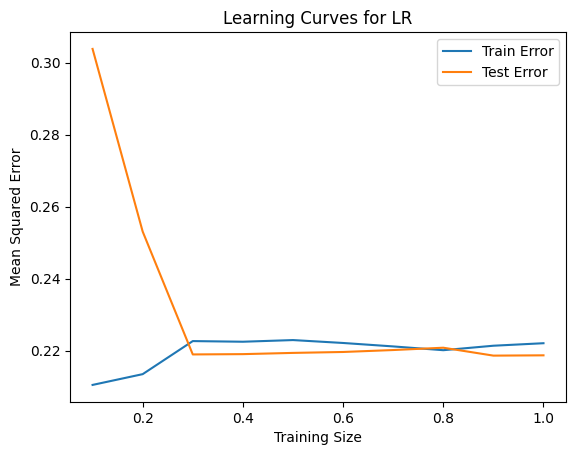

Mean Squared Error (MSE): 0.21872814566441745
Mean Absolute Error (MAE): 0.33647892890696024
R-squared (R²) Score: 0.599388311856228
Root Mean Squared Error (RMSE): 0.46768380949570776
Mean Squared Logarithmic Error (MSLE): 0.001246965598245752


In [70]:
X=df_2.copy()
y=y_1.copy()
model_type="LR" #possible: "KNR","LR","XGB"
metrics_lr=pre_model(X,y,model_type)

# c. KNN

Validation croisée :
MSE moyen: 0.21
Écart-type du MSE: 0.00

Sans validation croisée:


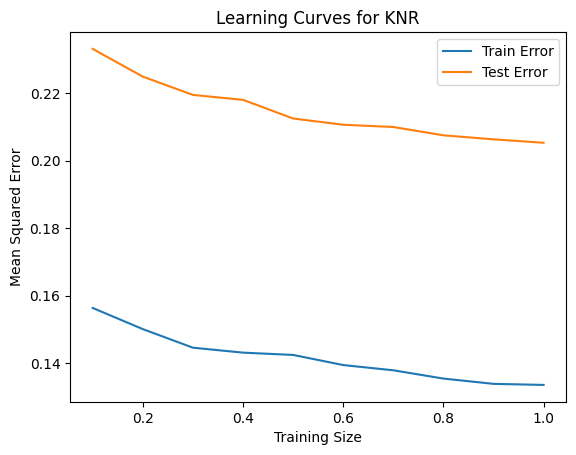

Mean Squared Error (MSE): 0.20524477713544897
Mean Absolute Error (MAE): 0.329838736918253
R-squared (R²) Score: 0.6240837849141034
Root Mean Squared Error (RMSE): 0.45303948739094363
Mean Squared Logarithmic Error (MSLE): 0.0011857836714638792


In [71]:
X=df_2.copy()
y=y_1.copy()
model_type="KNR" #possible: "KNR","LR","XGB"
metrics_knr=pre_model(X,y,model_type)

# d. XGB

Validation croisée :
MSE moyen: 0.17
Écart-type du MSE: 0.00

Sans validation croisée:


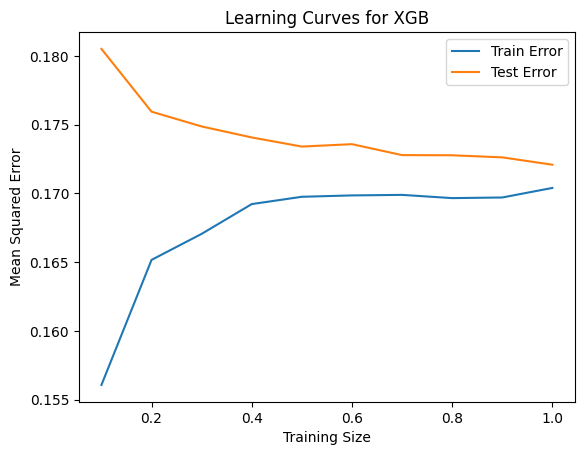

Mean Squared Error (MSE): 0.17208760961886174
Mean Absolute Error (MAE): 0.2916694790031261
R-squared (R²) Score: 0.6848128182652362
Root Mean Squared Error (RMSE): 0.4148344363946438
Mean Squared Logarithmic Error (MSLE): 0.00099752168855749


In [72]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
metrics_xgb,cv_results=pre_model(X,y,model_type)


In [74]:
mean_cv = {'mean MSE': np.mean(- cv_results['test_score']),'std MSE':np.std(- cv_results['test_score'])}
mean_cv

{'mean MSE': 0.17496849699842834, 'std MSE': 0.002211869929941981}

# Conclusion

In [76]:
df_lr = pd.DataFrame(metrics_lr[0], index=[0])
df_knr = pd.DataFrame(metrics_knr[0], index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_lr.rename(index={0: 'Linear Regression'}),
    df_knr.rename(index={0: 'KNR'}),
    df_xgb.rename(index={0: 'XGB'})
])
compa

,mse,mae,r2,rmse,msle
Linear Regression,0.218728,0.336479,0.599388,0.467684,0.001247
KNR,0.205245,0.329839,0.624084,0.453039,0.001186
XGB,0.172088,0.291669,0.684813,0.414834,0.000998


### Meilleur modèle: XGB

# 3. Amélioration du modèle XGB

## a. Etude des features

In [77]:
X=df_2.copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"
X_train,X_test,y_train,y_test=split_df(X,y)
model_xgb=initialize_model(model_type)

fitted_model_xgb=train_model(X_train,y_train,model_xgb)

# Importance des caractéristiques
importances = fitted_model_xgb.feature_importances_
# Création d'un DataFrame pour visualiser les importances
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df

,Feature,Importance
37,departement_75,0.662130
2,somme_surface_carrez,0.142507
36,departement_69,0.033571
34,departement_59,0.018502
30,departement_31,0.016356
0,surface_reelle_bati,0.015027
32,departement_34,0.010013
39,nombre_de_lots,0.007806
38,nombre_pieces_principales,0.007324
31,departement_33,0.006658


## b. Interprétation

#### Caractéristiques Principales : Les caractéristiques avec les plus hauts scores d'importance, comme departement_75 avec 0.511535 et somme_surface_carrez avec 0.165999, sont celles qui ont le plus d'impact sur les prédictions du modèle. Cela suggère que ces variables sont cruciales pour le modèle.

#### Caractéristiques Peu Importantes : Les variables avec des importances proches de zéro, comme type_de_voie_PL ou code_type_local_2, ont un impact négligeable sur les prédictions. Ces caractéristiques pourraient être considérées pour une éventuelle suppression si elles n'apportent pas de valeur ajoutée.

#### NB: Ici, nous garderons l'année puisque le modèle est entrainé que sur 2023 pour le moment

## c. Permutation importance

#### La permutation importance évalue l'importance d'une feature en mesurant la dégradation de la performance du modèle lorsque les valeurs de cette feature sont permutées.


In [78]:
# Calcul de l'importance des caractéristiques par permutation
results = permutation_importance(fitted_model_xgb, X_test, y_test, scoring='neg_mean_squared_error')

# Création d'un DataFrame pour visualiser les importances
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_importance_df


,Feature,Importance
37,departement_75,0.408533
2,somme_surface_carrez,0.310879
0,surface_reelle_bati,0.020628
38,nombre_pieces_principales,0.006095
34,departement_59,0.006012
36,departement_69,0.004480
30,departement_31,0.003657
39,nombre_de_lots,0.003478
32,departement_34,0.002937
5,type_de_voie_ALL,0.002120


## d. Colonne à forte influence 

In [79]:
# Exemple de seuil pour les importances
threshold = 0.003
important_features= importances_df[importances_df['Importance'] > threshold]

# Affichage des caractéristiques importantes
important_features

,Feature,Importance
37,departement_75,0.662130
2,somme_surface_carrez,0.142507
36,departement_69,0.033571
34,departement_59,0.018502
30,departement_31,0.016356
0,surface_reelle_bati,0.015027
32,departement_34,0.010013
39,nombre_de_lots,0.007806
38,nombre_pieces_principales,0.007324
31,departement_33,0.006658


## e. Essai du modèle sans Paris

Validation croisée :
MSE moyen: 0.19
Écart-type du MSE: 0.00

Sans validation croisée:


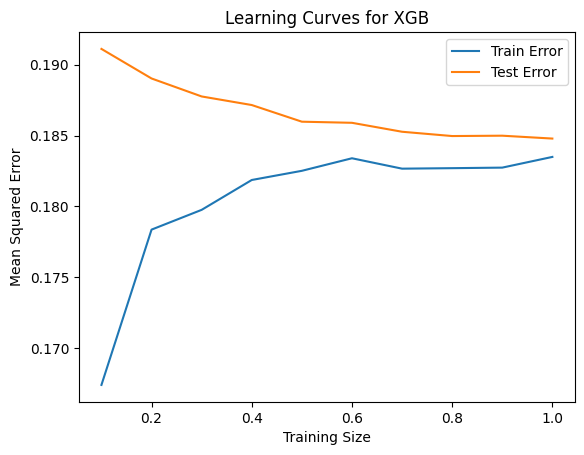

Mean Squared Error (MSE): 0.1847868185830213
Mean Absolute Error (MAE): 0.3085443421520856
R-squared (R²) Score: 0.6615535732066333
Root Mean Squared Error (RMSE): 0.42986837355523294
Mean Squared Logarithmic Error (MSLE): 0.0010649487781615894


In [80]:

X_sansP=df_2.drop(columns="departement_75").copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_xgb_sansP=pre_model(X_sansP,y,model_type)[0]


In [81]:
df_sansP = pd.DataFrame(metrics_xgb_sansP, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_sansP.rename(index={0: 'XGB sans Paris'}),
])
compa

,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
XGB sans Paris,0.184787,0.308544,0.661554,0.429868,0.001065


In [82]:
X_train,X_test,y_train,y_test=split_df(X_sansP,y)
model_sansP=initialize_model(model_type)

fitted_model_sansP=train_model(X_train,y_train,model_sansP)

# Importance des caractéristiques
importances = fitted_model_sansP.feature_importances_
# Création d'un DataFrame pour visualiser les importances
importances_df_sansP = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importances_df_sansP

,Feature,Importance
29,departement_13,0.142586
2,somme_surface_carrez,0.128347
30,departement_31,0.117659
32,departement_34,0.110688
36,departement_69,0.100467
34,departement_59,0.099088
31,departement_33,0.092155
33,departement_44,0.088528
35,departement_67,0.020701
37,nombre_pieces_principales,0.015524


## f. Essai du modèle sans département

Validation croisée :
MSE moyen: 0.36
Écart-type du MSE: 0.01

Sans validation croisée:


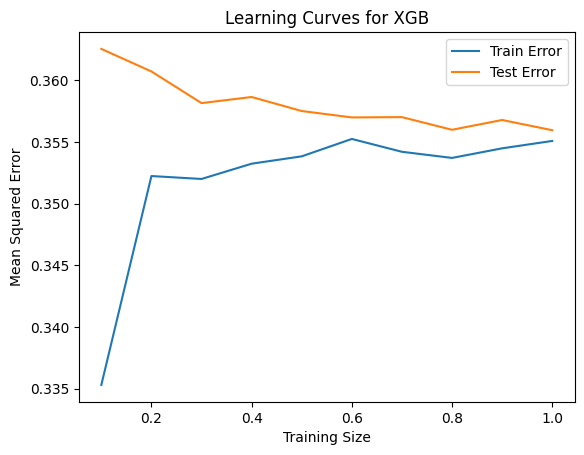

Mean Squared Error (MSE): 0.3559436346310361
Mean Absolute Error (MAE): 0.46354750448444376
R-squared (R²) Score: 0.3480711870874392
Root Mean Squared Error (RMSE): 0.5966101194507483
Mean Squared Logarithmic Error (MSLE): 0.0020013348965664452


,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
XGB sans departement,0.355944,0.463548,0.348071,0.596610,0.002001


In [84]:

# Créer une liste des colonnes qui ne commencent pas par 'departement'
colonnes_sans_departement = [col for col in df_2.columns if not col.startswith('departement')]

# Créer un nouveau DataFrame avec ces colonnes
X_sans_dpt = df_2[colonnes_sans_departement].copy()
y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_xgb_sans_dpt=pre_model(X_sans_dpt,y,model_type)[0]
df_sans_dpt = pd.DataFrame(metrics_xgb_sans_dpt, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_sans_dpt.rename(index={0: 'XGB sans departement'}),
])
compa

## Conclusion
#### Grosse influence de laspect géographique

## g. Modèle avec les 22 features les plus influentes (+ année)

Validation croisée :
MSE moyen: 0.18
Écart-type du MSE: 0.00

Sans validation croisée:


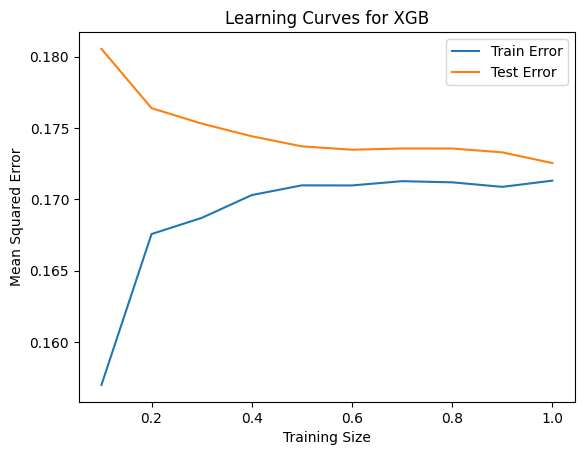

Mean Squared Error (MSE): 0.17254034883724917
Mean Absolute Error (MAE): 0.29188497565197674
R-squared (R²) Score: 0.6839836034332076
Root Mean Squared Error (RMSE): 0.41537976459771025
Mean Squared Logarithmic Error (MSLE): 0.000999999310229942


,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
XGB avec 22 features + importantes,0.172540,0.291885,0.683984,0.415380,0.001000


In [85]:
# Exemple de seuil pour les importances
threshold = 0.003
important_features= importances_df[importances_df['Importance'] > threshold]

# Affichage des caractéristiques importantes
important_features
X_important=df_2[important_features['Feature']].copy()
X_important['year_mutation_2023']=df_2['year_mutation_2023']
X_important

y=y_1.copy()
model_type="XGB" #possible: "KNR","LR","XGB"

metrics_important_features=pre_model(X_important,y,model_type)[0]
df__important_features= pd.DataFrame(metrics_important_features, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df__important_features.rename(index={0: 'XGB avec 22 features + importantes'}),
])
compa

# 4. PCA

#### Le PCA (Principal Component Analysis) est une technique de réduction de dimensionnalité utilisée pour simplifier les données tout en conservant le maximum de leur variance. 

#### Le PCA est une méthode statistique qui transforme un ensemble de variables corrélées en un ensemble de variables non corrélées appelées composantes principales. Ces nouvelles variables sont des combinaisons linéaires des variables d'origine et sont classées par ordre d'importance (variabilité des données).

In [87]:
def test_pca(df,y, model_type,n_components=df_2.shape[1]):
    X_train,X_test,y_train,y_test=split_df(df,y)
    pca = PCA(n_components=n_components)
    # Appliquer le PCA sur X_train et X_test
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model_XGB = initialize_model(model_type)

    # Validation croisée sur les données transformées par PCA
    cv_results_XGB_pca = cross_validate_model(X_train_pca, y_train, model_XGB)

    # Entraîner le modèle sur les données réduites
    fitted_model_XGB_pca = train_model(X_train_pca, y_train, model_XGB)
    print("\nSans validation croisée:")
    # Évaluer le modèle sur les données de test transformées
    metrics_XGB_pca = evaluate_model(X_test_pca, y_test, fitted_model_XGB_pca, model_type)


    return metrics_XGB_pca


## a. PCA avec la moitié des features

In [88]:
n_components = int(X_train.shape[1]/2) # Vous pouvez aussi définir un nombre fixe de composantes comme n_components=20
model_type = "XGB"
metrics_XGB_pca =test_pca(df_2,y_1, model_type,n_components)
df_XGB_pca = pd.DataFrame(metrics_XGB_pca, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_XGB_pca.rename(index={0: 'XGB avce PCA'}),
])
compa

Validation croisée :
MSE moyen: 0.18
Écart-type du MSE: 0.00

Sans validation croisée:
Mean Squared Error (MSE): 0.17986431939654782
Mean Absolute Error (MAE): 0.29955805155310067
R-squared (R²) Score: 0.6705693800338216
Root Mean Squared Error (RMSE): 0.4241041374433263
Mean Squared Logarithmic Error (MSLE): 0.001040054495359555


,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
XGB avce PCA,0.179864,0.299558,0.670569,0.424104,0.001040


## b. Recherche du nombre de composantes pour PCA

### ***Choix de n_components par validation croisée***

In [89]:

# Test de différents nombres de composants
n_components_range = range(1,df_2.shape[1] + 1)
scores = []

for n in n_components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(df_2)
    model_XGB = initialize_model(model_type)
    score = cross_val_score(model_XGB, X_pca, y_1, cv=5).mean()
    scores.append(score)


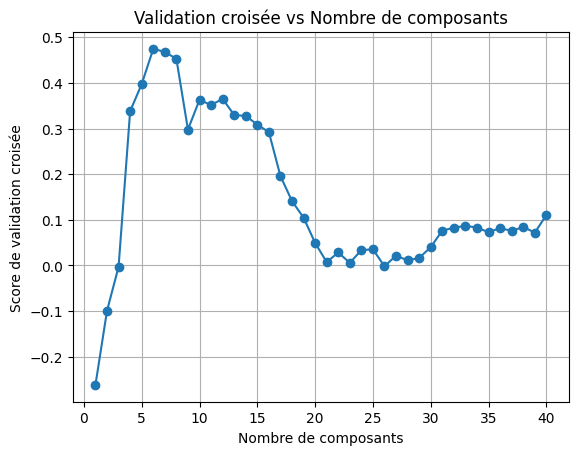

In [90]:

# Tracer les scores
plt.plot(n_components_range, scores, marker='o')
plt.xlabel('Nombre de composants')
plt.ylabel('Score de validation croisée')
plt.title('Validation croisée vs Nombre de composants')
plt.grid(True)
plt.show()

#### **Graphe se stabilise à 35**

In [91]:
# Trouver l'indice du meilleur score
best_index = np.argmax(scores)
# Correspondre l'indice avec le nombre de composants
best_n_components = n_components_range[best_index]

best_n_components

6

#### **Meilleur score atteint à 6**

### ***Verification par graph de la variance expliquée cumulée***


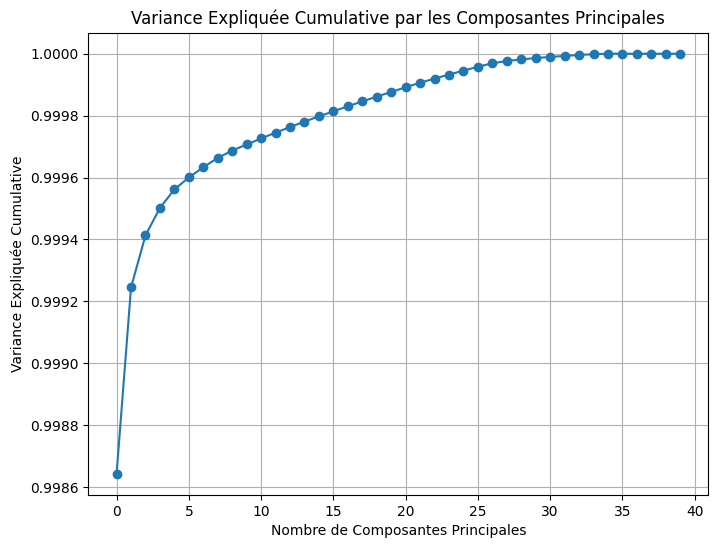

In [92]:
# Appliquer PCA
pca = PCA()
X_pca = pca.fit_transform(df_2)

# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Tracer la variance expliquée cumulée
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.title('Variance Expliquée Cumulative par les Composantes Principales')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulative')
plt.grid(True)
plt.show()

## c. Essai avec 6 puis 32

In [93]:
metrics_XGB_pca_6=test_pca(df_2,y_1, model_type,n_components = 6)
df_pca_6 = pd.DataFrame(metrics_XGB_pca_6, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_pca_6.rename(index={0: 'PCA 6 composantes'}),
])
compa

Validation croisée :
MSE moyen: 0.19
Écart-type du MSE: 0.00

Sans validation croisée:
Mean Squared Error (MSE): 0.18650488810241253
Mean Absolute Error (MAE): 0.3048319291796551
R-squared (R²) Score: 0.6584068417769816
Root Mean Squared Error (RMSE): 0.4318621170031154
Mean Squared Logarithmic Error (MSLE): 0.0010775392002881547


,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
PCA 6 composantes,0.186505,0.304832,0.658407,0.431862,0.001078


In [94]:
metrics_XGB_pca_35=test_pca(df_2,y_1, model_type,n_components = 35)
df_pca_35 = pd.DataFrame(metrics_XGB_pca_35, index=[0])
df_xgb = pd.DataFrame(metrics_xgb, index=[0])

# Créer un DataFrame pour stocker les résultats
compa = pd.DataFrame()

# Ajouter les résultats des modèles
compa = pd.concat([
    compa,
    df_xgb.rename(index={0: 'XGB'}),
    df_pca_35.rename(index={0: 'PCA 35 composantes'}),
])
compa

Validation croisée :
MSE moyen: 0.18
Écart-type du MSE: 0.00

Sans validation croisée:
Mean Squared Error (MSE): 0.17677615853285988
Mean Absolute Error (MAE): 0.2976289698937411
R-squared (R²) Score: 0.6762255032231969
Root Mean Squared Error (RMSE): 0.42044756930307003
Mean Squared Logarithmic Error (MSLE): 0.0010217017938684786


,mse,mae,r2,rmse,msle
XGB,0.172088,0.291669,0.684813,0.414834,0.000998
PCA 35 composantes,0.176776,0.297629,0.676226,0.420448,0.001022


## Conclusion: mieux avec 35

### Interprétation résultats:
#### Résultats de validation croisée et sans validation croisée montrent des valeurs de MSE (Mean Squared Error) très proches => modèle consistant et ne souffre pas de sur-apprentissage (overfitting) ni de sous-apprentissage (underfitting), ce qui est positif. 



#### MAE proche de MSE:  erreurs dans prédictions probablement uniformément réparties, sans trop d'erreurs très grandes.


#### R2 ok

